<a href="https://colab.research.google.com/github/MuhammadIrzam447/visionCodes/blob/master/Updated_Ex_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# performed augmentation on class 1 only to make it more balance.
# extract best model

In [ ]:
# Fused Hateful Memes
# !gdown https://drive.google.com/uc?id=1njfaNGVKJMDdBDV1CwQyrrvwyUzSdsTj

In [ ]:
# !unzip /content/hateful_exp5.zip

In [3]:
from google.colab import drive
import pandas as pd
import os
from PIL import Image
import torch
import torchvision
from torchvision import datasets, transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import UnidentifiedImageError
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


# Loading Training Dataset and Preprocessing

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
class TrainingDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.dataset = datasets.ImageFolder(data_dir, transform=transform)
        self.classes = sorted(os.listdir(data_dir))
        self.class_lengths = self._compute_class_lengths()
        self.num_classes = len(self.dataset.classes)

    def _compute_class_lengths(self):
        class_lengths = {cls: 0 for cls in self.classes}

        for cls in self.classes:
            cls_dir = os.path.join(self.data_dir, cls)
            if os.path.isdir(cls_dir):
                class_lengths[cls] = len(os.listdir(cls_dir))

        return class_lengths

    def __getitem__(self, index):
        image, label = self.dataset[index]
        return image, label

    # def __getitem__(self, index):
    #     while True:
    #         try:
    #             image, label = self.dataset[index]
    #             return image, label
    #         except (UnidentifiedImageError, FileNotFoundError) as e:
    #             print(f"Error loading image at index {index}: {e}")
    #             index += 1

    def __len__(self):
        return len(self.dataset)

    def get_num_classes(self):
        return self.num_classes

In [7]:
data_dir = "/content/mulitmodal/train"
dataset = TrainingDataset(data_dir)

In [8]:
print("Number of samples:", len(dataset))
print("Number of classes:", len(dataset.classes))

Number of samples: 28550
Number of classes: 2


In [9]:
batch_size = 32
num_workers = 2
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# Validation Data Loader

In [10]:
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class ValidationDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.dataset = datasets.ImageFolder(data_dir, transform=val_transform)
        self.classes = sorted(os.listdir(data_dir))
        self.class_lengths = self._compute_class_lengths()

    def _compute_class_lengths(self):
        class_lengths = {cls: 0 for cls in self.classes}

        for cls in self.classes:
            cls_dir = os.path.join(self.data_dir, cls)
            if os.path.isdir(cls_dir):
                class_lengths[cls] = len(os.listdir(cls_dir))

        return class_lengths

    def __getitem__(self, index):
        image, label = self.dataset[index]
        return image, label

    def __len__(self):
        return len(self.dataset)

In [11]:
valPath = "/content/mulitmodal/test"
val_dataset = ValidationDataset(valPath)

In [12]:
batch_size = 32
validation_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [13]:
print("Number of samples:", len(val_dataset))
print("Number of classes:", len(val_dataset.classes))

Number of samples: 2000
Number of classes: 2


# EDA

In [ ]:
class_length = dataset.class_lengths
class_labels = list(class_length.keys())

In [ ]:
from torchvision.transforms import ToPILImage

def plot_sample_images(dataset):


    # Create a grid layout based on the number of classes
    num_classes = len(class_length)
    grid_cols = 4  # Number of columns in the grid
    grid_rows = (num_classes + grid_cols - 1) // grid_cols  # Number of rows in the grid
    plt.figure(figsize=(10, 5 * grid_rows))

    # Create a transform to convert the tensor to PIL Image
    to_pil = ToPILImage()

    # Iterate over each class
    for i, class_label in enumerate(class_labels):
        # Get a random image index from the class
        image_index = np.random.choice(class_length[class_label])

        # Get the image and label from the dataset
        image, label = dataset[image_index]

        # Convert the image tensor to PIL Image
        image = to_pil(image)

        # Plot the image
        plt.subplot(grid_rows, grid_cols, i + 1)
        plt.imshow(image, interpolation='none')  # Use 'RGB' interpolation
        plt.title(class_label)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
plot_sample_images(dataset)

In [14]:
class_lengths_dict = dataset.class_lengths
total_sum = sum(class_lengths_dict.values())
dict_length = len(class_lengths_dict)

# Print the length
print("Dictionary length:", dict_length)
# Print the total sum
print("Total sum:", total_sum)
print(class_lengths_dict.values())

Dictionary length: 2
Total sum: 28550
dict_values([16350, 12200])


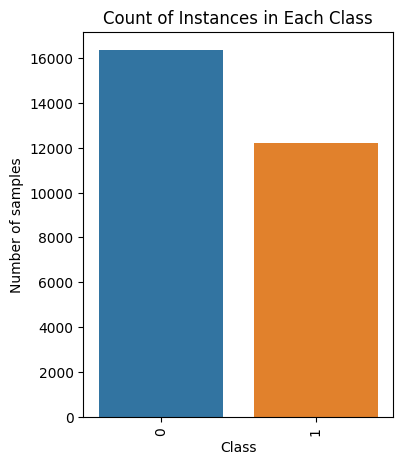

In [15]:
# Extract class labels and counts from the dictionary
class_labels = list(class_lengths_dict.keys())
class_counts = list(class_lengths_dict.values())

# Create a count plot
plt.figure(figsize=(4, 5))
sns.barplot(x=class_labels, y=class_counts)
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Count of Instances in Each Class')
plt.show()

# Loading ResNet-101

In [16]:
num_classes = dataset.get_num_classes()
print("Number of classes:", num_classes)

Number of classes: 2


In [ ]:
resnet = torchvision.models.resnet101(pretrained=True)
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, num_classes)  # num_classes is the number of classes in your dataset
resnet.to(device)
print(resnet)

# Fine Tuning

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)
num_epochs = 25

In [19]:
training_loss = []

for epoch in range(num_epochs):
    # Set the model to training mode
    resnet.train()
    running_loss = 0.0

    # Iterate over the data loader
    for images, labels in data_loader:
        # Move the images and labels to the GPU if available
        images = images.to(device)
        labels = labels.to(device)

        # Clear the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = resnet(images)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update the running loss
        running_loss += loss.item() * images.size(0)

    # Calculate the average loss for the epoch
    epoch_loss = running_loss / len(data_loader.dataset)
    training_loss.append(epoch_loss)
    # Print the epoch loss
    print("Training Loss==========================>>")
    print(f"Epoch {epoch+1}/{num_epochs} Training Loss: {epoch_loss:.4f}")

    resnet.eval()
    predicted_classes = []
    actual_labels = []
    with torch.no_grad():
        for images, labels in validation_data_loader:
            # Move the images and labels to the GPU if available
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = resnet(images)

            # Get the predicted labels
            _, predicted_label = torch.max(outputs, 1)

            # Store the predicted and true labels
            predicted_classes.extend(predicted_label.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())

    accuracy = accuracy_score(actual_labels, predicted_classes)
    precision = precision_score(actual_labels, predicted_classes, average='weighted')
    recall = recall_score(actual_labels, predicted_classes, average='weighted')
    f1 = f1_score(actual_labels, predicted_classes, average='weighted')

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)

    print(classification_report(actual_labels, predicted_classes))
    print("Confusion Matrix: ")
    cm = confusion_matrix(actual_labels, predicted_classes)
    print(cm)

    save_dir = "/content/Models/"
    os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist

    model_name = str(epoch+1) + "_model.pth"
    save_path = os.path.join(save_dir, model_name)  # Specify the complete path to the model file
    torch.save(resnet.state_dict(), save_path)

Training Loss==========================>>
Epoch 1/25 Training Loss: 0.4531
Accuracy: 0.62
Precision: 0.5756944444444444
Recall: 0.62
F1-score: 0.5442622950819672
              precision    recall  f1-score   support

           0       0.64      0.92      0.75      1250
           1       0.47      0.13      0.20       750

    accuracy                           0.62      2000
   macro avg       0.56      0.52      0.48      2000
weighted avg       0.58      0.62      0.54      2000

Confusion Matrix: 
[[1145  105]
 [ 655   95]]
Training Loss==========================>>
Epoch 2/25 Training Loss: 0.2986
Accuracy: 0.593
Precision: 0.5691968799091658
Recall: 0.593
F1-score: 0.5735316494217894
              precision    recall  f1-score   support

           0       0.65      0.77      0.70      1250
           1       0.44      0.31      0.36       750

    accuracy                           0.59      2000
   macro avg       0.54      0.54      0.53      2000
weighted avg       0.57      

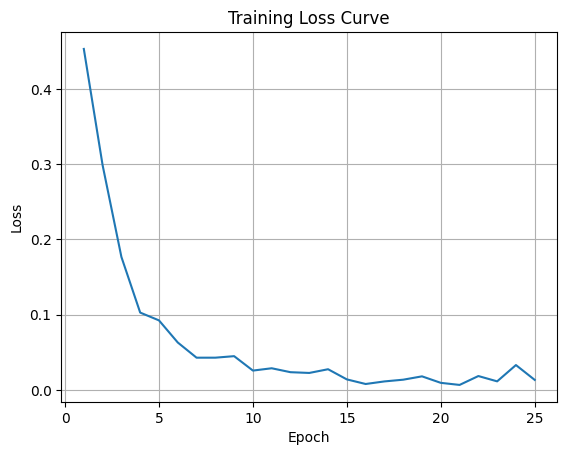

In [20]:
# Plot the loss curve
plt.plot(range(1, num_epochs+1), training_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.show()

# Save Model

In [ ]:
# save_dir = "/content/Model/Fused_ResNetmodel_Hatefull_Experiment#5"
# os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist

# save_path = os.path.join(save_dir, 'model.pth')  # Specify the complete path to the model file
# torch.save(resnet.state_dict(), save_path)

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
%cd /content/Models

/content/Models


In [24]:
!cp 21_model.pth /content/drive/MyDrive/21_model.pth
